In [6]:
from builtins import sorted
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import re
import os
import sys
import shutil
import pandas as pd
from tabulate import tabulate
import pickle
import madmom
import sklearn

from tensorflow import keras
import tensorflow
from tensorflow.keras import datasets, layers, models, regularizers, optimizers, callbacks

print(tensorflow.__version__)

2.4.1


In [7]:
path = "./HW1 Datasets/GTZAN/GTZAN/wav"

genres_list = ['disco', 'reggae', 'pop', 'rock',
               'metal', 'jazz', 'blues', 'hiphop', 'country']

template_types = ['binary', 'ks', 'harmonic']
chroma_operations = ['stft', 'cqt', 'cens']

binary_correct_accumulate_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                                  'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

binary_file_num_dict = {'disco': 0, 'reggae': 0, 'pop': 0, 'rock': 0,
                        'metal': 0, 'jazz': 0, 'blues': 0, 'hiphop': 0, 'country': 0}

moving_scale = {-1:'-1', 0: '15', 1: '16', 2: '17', 3: '18', 4: '19', 5: '20',
                6: '21', 7: '22', 8: '23', 9: '0', 10: '1', 11: '2',
                12: '3', 13: '4', 14: '5', 15: '6', 16: '7', 17: '8',
                18: '9', 19: '10', 20: '11', 21: '12', 22: '13', 23: '14',
                }

annotation_major_scale = ['A', 'A#', 'B', 'C', 'C#','D',
                          'D#', 'E', 'F', 'F#', 'G', 'G#']

annotation_minor_scale = ['a', 'a#', 'b', 'c', 'c#', 'd',
                          'd#', 'e', 'f', 'f#', 'g', 'g#']

octave_scale = ['C', 'C#', 'D', 'D#', 'E', 'F',
                'F#', 'G', 'G#', 'A', 'A#', 'B']


In [8]:
# -- 1) binary-valued template matching
# -- 2) K-S template matching
# -- 3) harmonic template matching (try 𝛼 = 0.9).
# -- Using Cicular Shifting to generate another tone

binary_C_major = [1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1]
binary_C_minor = [1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0]

# -- C, C#, D, D#, E, F, F#, G, G#, A, A#, B
KS_C_major = [6.35, 2.23, 3.48, 2.33, 4.38,
              4.09, 2.52, 5.19, 2.39, 3.66, 2.29, 2.88]
KS_C_minor = [6.33, 2.68, 3.52, 5.38, 2.60,
              3.53, 2.54, 4.75, 3.98, 2.69, 3.34, 3.17]

binary_templates = [binary_C_major, binary_C_minor]
ks_templates = [KS_C_major, KS_C_minor]

alpha = 0.9

# C Major harmonic template
C_major_harmonic_template = [1 + alpha + alpha**3 + alpha**7, 0, 0, 0, alpha**4, 0,
                             0, alpha**2+alpha**5, 0, 0, alpha**6, 0]

all_pitches_harmonic_template = [0] * 12

# Get all pitchs harmonic template
for i in range(12):
    all_pitches_harmonic_template[i] = np.roll(C_major_harmonic_template, i-3)

harmonic_major_template = [0] * 12
harmonic_minor_template = [0] * 12

for i in range(12):
    if binary_templates[0][i] == 1:
        harmonic_major_template += all_pitches_harmonic_template[(i + 3) % 12]

for i in range(12):
    if binary_templates[1][i] == 1:
        harmonic_minor_template += all_pitches_harmonic_template[(i + 3) % 12]

harmonic_templates = [harmonic_major_template, harmonic_minor_template]

templates = {'binary':binary_templates, 'ks':ks_templates, 'harmonic':harmonic_templates}

In [4]:
def sort_key_num(name_file:str, str_key=str.lower, nzero:int=5) -> str:
    return str_key( re.sub("(.[0-9]+)",lambda x: x.group(0).zfill(nzero),name_file) )

In [9]:
for root, dirs, files in os.walk(path):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".wav")):
            # print("============")
            # print("sorted_name", name)
            txt_file_path = name.replace(".wav", ".lerch.txt")
            txt_file_path = txt_file_path.replace("wav", "key")
            name_split = txt_file_path.split('.')
            #print("txt_file_path = ", txt_file_path)
            genre = txt_file_path.split(".")[0]
            binary_file_num_dict[genre] += 1
            y, sr = librosa.load(
                r"./HW1 Datasets/GTZAN/GTZAN/wav/" + genre + "/" + name, sr = 22050, mono = True, dtype = np.float32) #duration setting

            # -- CQT chromagram
            chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)
            chroma_cqt_row_totals = chroma_cqt.sum(axis=1)

            f_ground_truth = open(str("./HW1 Datasets/GTZAN/GTZAN/key/" + genre + "/" + txt_file_path),"r")
            #fc #moving_scale
            key_gt = moving_scale[int(f_ground_truth.readline().rstrip())]
            #print(key_gt)

            filename = os.path.split(name)[1]
            filename = os.path.splitext(filename)[0]
            filename = "./temp/GTZAN_analysis_Q6/chroma_cqt/cqt." + name_split[0]+ "." + name_split[1] + "." + key_gt + ".csv"
            #print(filename)
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, 'a+') as f:
                np.savetxt(filename, chroma_cqt_row_totals)


In [ ]:
deep_chroma_list = []
for root, dirs, files in os.walk("./temp/GTZAN_analysis_Q6/chroma_cqt/"):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".csv")):
            deep_chroma_list.append(name)

deep_chroma_list

deep_chroma_list_unknown = list(filter(lambda x: "-1" in x, deep_chroma_list))

In [ ]:
for item in deep_chroma_list_unknown:
    deep_chroma_list.remove(item)

In [ ]:
deep_chroma_list

['cqt.blues.00000.13.csv',
 'cqt.blues.00001.10.csv',
 'cqt.blues.00002.10.csv',
 'cqt.blues.00003.10.csv',
 'cqt.blues.00004.4.csv',
 'cqt.blues.00005.12.csv',
 'cqt.blues.00006.11.csv',
 'cqt.blues.00007.4.csv',
 'cqt.blues.00008.10.csv',
 'cqt.blues.00009.13.csv',
 'cqt.blues.00010.11.csv',
 'cqt.blues.00011.10.csv',
 'cqt.blues.00012.5.csv',
 'cqt.blues.00013.4.csv',
 'cqt.blues.00014.4.csv',
 'cqt.blues.00015.4.csv',
 'cqt.blues.00016.3.csv',
 'cqt.blues.00017.3.csv',
 'cqt.blues.00018.4.csv',
 'cqt.blues.00019.3.csv',
 'cqt.blues.00020.10.csv',
 'cqt.blues.00021.11.csv',
 'cqt.blues.00022.11.csv',
 'cqt.blues.00023.3.csv',
 'cqt.blues.00024.4.csv',
 'cqt.blues.00025.4.csv',
 'cqt.blues.00026.4.csv',
 'cqt.blues.00027.4.csv',
 'cqt.blues.00028.4.csv',
 'cqt.blues.00029.8.csv',
 'cqt.blues.00030.6.csv',
 'cqt.blues.00031.8.csv',
 'cqt.blues.00032.6.csv',
 'cqt.blues.00033.11.csv',
 'cqt.blues.00034.8.csv',
 'cqt.blues.00035.16.csv',
 'cqt.blues.00036.11.csv',
 'cqt.blues.00037.11.c

In [ ]:
len(deep_chroma_list)

837

In [ ]:
deep_chroma_list[0].split('.')[3]

'13'

In [ ]:
N = len(deep_chroma_list)

dataset = np.zeros((N,1,12))
target  = np.zeros((N))

for i in range(0, N):
  target[i] = deep_chroma_list[i].split('.')[3]
  print("target[i]: ", target[i])
  data = np.loadtxt("./temp/GTZAN_analysis_Q6/chroma_cqt/" + deep_chroma_list[i])
  #print(data.shape)
  data = data
  dataset[i,:] = data

print(data)
print(dataset.shape)
print(target.shape)

with open("./temp/GTZAN_analysis_Q6/input.pkl", "wb") as f:
  pickle.dump(dataset, f)

with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
  x = pickle.load(f)

print(x.shape)

with open("./temp/GTZAN_analysis_Q6/output.pkl", "wb") as f:
  pickle.dump(target, f)
    
with open("./temp/GTZAN_analysis_Q6/output.pkl", "rb") as f:
  x = pickle.load(f)

print(x.shape)

target[i]:  13.0
target[i]:  10.0
target[i]:  10.0
target[i]:  10.0
target[i]:  4.0
target[i]:  12.0
target[i]:  11.0
target[i]:  4.0
target[i]:  10.0
target[i]:  13.0
target[i]:  11.0
target[i]:  10.0
target[i]:  5.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  3.0
target[i]:  3.0
target[i]:  4.0
target[i]:  3.0
target[i]:  10.0
target[i]:  11.0
target[i]:  11.0
target[i]:  3.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  8.0
target[i]:  6.0
target[i]:  8.0
target[i]:  6.0
target[i]:  11.0
target[i]:  8.0
target[i]:  16.0
target[i]:  11.0
target[i]:  11.0
target[i]:  8.0
target[i]:  11.0
target[i]:  2.0
target[i]:  10.0
target[i]:  13.0
target[i]:  5.0
target[i]:  9.0
target[i]:  9.0
target[i]:  9.0
target[i]:  7.0
target[i]:  9.0
target[i]:  9.0
target[i]:  5.0
target[i]:  10.0
target[i]:  13.0
target[i]:  14.0
target[i]:  3.0
target[i]:  13.0
target[i]:  10.0
target[i]:  5.0
target[i]:  13.0
target[i]:  13.0
target[i]:  3

In [ ]:
with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
  dataset = pickle.load(f)

with open("./temp/GTZAN_analysis_Q6/output.pkl","rb") as f:
  target = pickle.load(f)

In [ ]:
chroma_cqt_list = [item.replace('csv', 'txt') for item in deep_chroma_list]

In [ ]:
chroma_cqt_list

['cqt.blues.00000.13.txt',
 'cqt.blues.00001.10.txt',
 'cqt.blues.00002.10.txt',
 'cqt.blues.00003.10.txt',
 'cqt.blues.00004.4.txt',
 'cqt.blues.00005.12.txt',
 'cqt.blues.00006.11.txt',
 'cqt.blues.00007.4.txt',
 'cqt.blues.00008.10.txt',
 'cqt.blues.00009.13.txt',
 'cqt.blues.00010.11.txt',
 'cqt.blues.00011.10.txt',
 'cqt.blues.00012.5.txt',
 'cqt.blues.00013.4.txt',
 'cqt.blues.00014.4.txt',
 'cqt.blues.00015.4.txt',
 'cqt.blues.00016.3.txt',
 'cqt.blues.00017.3.txt',
 'cqt.blues.00018.4.txt',
 'cqt.blues.00019.3.txt',
 'cqt.blues.00020.10.txt',
 'cqt.blues.00021.11.txt',
 'cqt.blues.00022.11.txt',
 'cqt.blues.00023.3.txt',
 'cqt.blues.00024.4.txt',
 'cqt.blues.00025.4.txt',
 'cqt.blues.00026.4.txt',
 'cqt.blues.00027.4.txt',
 'cqt.blues.00028.4.txt',
 'cqt.blues.00029.8.txt',
 'cqt.blues.00030.6.txt',
 'cqt.blues.00031.8.txt',
 'cqt.blues.00032.6.txt',
 'cqt.blues.00033.11.txt',
 'cqt.blues.00034.8.txt',
 'cqt.blues.00035.16.txt',
 'cqt.blues.00036.11.txt',
 'cqt.blues.00037.11.t

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

N = len(target)
dataset = np.expand_dims(dataset,axis=-1)
print(N)		
print(dataset.shape)
print(target.shape)

837
(837, 1, 12, 1)
(837,)


In [ ]:
n = 668

2022-04-28 15:57:56.288172: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-04-28 15:57:56.288324: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-28 15:57:56.288870: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2022-04-28 15:57:56.383967: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-04-28 15:57:56.406241: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3693310000 Hz


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 1, 12, 24)         624       
_________________________________________________________________
batch_normalization (BatchNo (None, 1, 12, 24)         96        
_________________________________________________________________
dropout (Dropout)            (None, 1, 12, 24)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 1, 12, 24)         14424     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 12, 24)         96        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 12, 24)         14424     
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 12, 24)         9

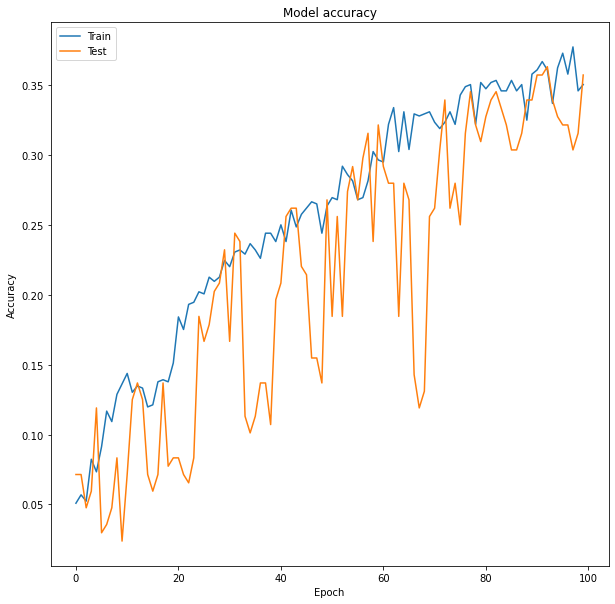

6/6 - 0s - loss: 89.4135 - accuracy: 0.3571


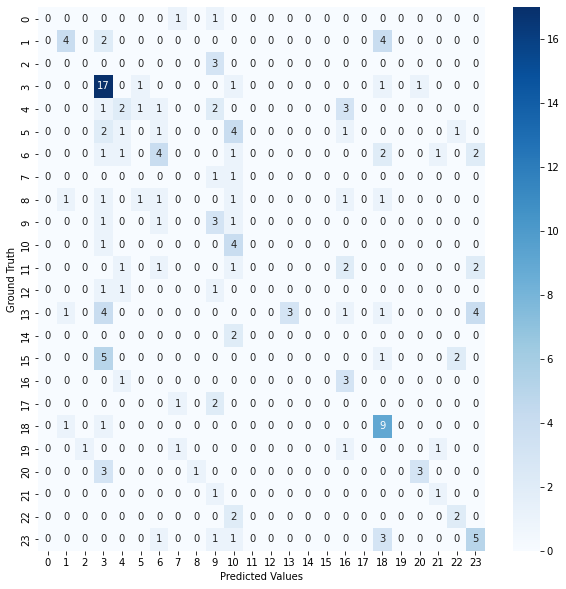


Evaluation accuracy: 35.71 % - loss: 89.41


In [ ]:
model = models.Sequential()
model.add(layers.Conv2D(24, (5,5), kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same', input_shape=(1,12,1)))# input_shape=(144,150,1)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.AveragePooling2D(pool_size = (1,12)))
model.add(layers.Flatten())

model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

model.summary()
sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nTraining")

callback = [callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) , callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
 
history = model.fit(dataset[:n,:,:], target[:n], epochs=100,verbose=1,validation_data = (dataset[n+1:,:,:], target[n+1:]),callbacks=callback)

print("\nModel Trained, Evaluation: \n")
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(dataset[n+1:,:,:], target[n+1:], verbose=2)

if True:
  y_pred = model.predict(dataset[n+1:,:,:])
  matrix = sklearn.metrics.confusion_matrix(keras.utils.to_categorical(target[n+1:]).argmax(axis=1), y_pred.argmax(axis=1))
  figure = plt.figure(figsize=(10, 10))
  import seaborn as sns
  sns.heatmap(matrix, annot=True, cmap = plt.cm.Blues)
  plt.xlabel('Predicted Values')
  plt.ylabel('Ground Truth')
  plt.show()

print('\nEvaluation accuracy: %.2f %% - loss: %.2f' % (acc*100, loss))


## Don't accumulate chromagram

In [10]:
for root, dirs, files in os.walk(path):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".wav")):
            # print("============")
            # print("sorted_name", name)
            txt_file_path = name.replace(".wav", ".lerch.txt")
            txt_file_path = txt_file_path.replace("wav", "key")
            name_split = txt_file_path.split('.')
            #print("txt_file_path = ", txt_file_path)
            genre = txt_file_path.split(".")[0]
            binary_file_num_dict[genre] += 1
            y, sr = librosa.load(
                r"./HW1 Datasets/GTZAN/GTZAN/wav/" + genre + "/" + name, sr = 22050, mono = True, dtype = np.float32) #duration setting

            # -- CQT chromagram
            chroma_cqt = librosa.feature.chroma_cqt(y=y, sr=sr)

            f_ground_truth = open(str("./HW1 Datasets/GTZAN/GTZAN/key/" + genre + "/" + txt_file_path),"r")
            #fc #moving_scale
            key_gt = moving_scale[int(f_ground_truth.readline().rstrip())]
            #print(key_gt)

            filename = os.path.split(name)[1]
            filename = os.path.splitext(filename)[0]
            filename = "./temp/GTZAN_analysis_Q6/chroma_cqt_all/cqt." + name_split[0]+ "." + name_split[1] + "." + key_gt + ".csv"
            #print(filename)
            os.makedirs(os.path.dirname(filename), exist_ok=True)
            with open(filename, 'a+') as f:
                np.savetxt(filename, chroma_cqt)


In [13]:
chroma_list = []
for root, dirs, files in os.walk("./temp/GTZAN_analysis_Q6/chroma_cqt_all/"):
    files = sorted(files, key=sort_key_num)
    #print(files)

    for index, name in enumerate(files):
        if name.endswith((".csv")):
            chroma_list.append(name)

chroma_list

['cqt.blues.00000.13.csv',
 'cqt.blues.00001.10.csv',
 'cqt.blues.00002.10.csv',
 'cqt.blues.00003.10.csv',
 'cqt.blues.00004.4.csv',
 'cqt.blues.00005.12.csv',
 'cqt.blues.00006.11.csv',
 'cqt.blues.00007.4.csv',
 'cqt.blues.00008.10.csv',
 'cqt.blues.00009.13.csv',
 'cqt.blues.00010.11.csv',
 'cqt.blues.00011.10.csv',
 'cqt.blues.00012.5.csv',
 'cqt.blues.00013.4.csv',
 'cqt.blues.00014.4.csv',
 'cqt.blues.00015.4.csv',
 'cqt.blues.00016.3.csv',
 'cqt.blues.00017.3.csv',
 'cqt.blues.00018.4.csv',
 'cqt.blues.00019.3.csv',
 'cqt.blues.00020.10.csv',
 'cqt.blues.00021.11.csv',
 'cqt.blues.00022.11.csv',
 'cqt.blues.00023.3.csv',
 'cqt.blues.00024.4.csv',
 'cqt.blues.00025.4.csv',
 'cqt.blues.00026.4.csv',
 'cqt.blues.00027.4.csv',
 'cqt.blues.00028.4.csv',
 'cqt.blues.00029.8.csv',
 'cqt.blues.00030.6.csv',
 'cqt.blues.00031.8.csv',
 'cqt.blues.00032.6.csv',
 'cqt.blues.00033.11.csv',
 'cqt.blues.00034.8.csv',
 'cqt.blues.00035.16.csv',
 'cqt.blues.00036.11.csv',
 'cqt.blues.00037.11.c

In [15]:
deep_chroma_list_unknown = list(filter(lambda x: "-1" in x, chroma_list))
for item in deep_chroma_list_unknown:
    chroma_list.remove(item)

chroma_list

['cqt.blues.00000.13.csv',
 'cqt.blues.00001.10.csv',
 'cqt.blues.00002.10.csv',
 'cqt.blues.00003.10.csv',
 'cqt.blues.00004.4.csv',
 'cqt.blues.00005.12.csv',
 'cqt.blues.00006.11.csv',
 'cqt.blues.00007.4.csv',
 'cqt.blues.00008.10.csv',
 'cqt.blues.00009.13.csv',
 'cqt.blues.00010.11.csv',
 'cqt.blues.00011.10.csv',
 'cqt.blues.00012.5.csv',
 'cqt.blues.00013.4.csv',
 'cqt.blues.00014.4.csv',
 'cqt.blues.00015.4.csv',
 'cqt.blues.00016.3.csv',
 'cqt.blues.00017.3.csv',
 'cqt.blues.00018.4.csv',
 'cqt.blues.00019.3.csv',
 'cqt.blues.00020.10.csv',
 'cqt.blues.00021.11.csv',
 'cqt.blues.00022.11.csv',
 'cqt.blues.00023.3.csv',
 'cqt.blues.00024.4.csv',
 'cqt.blues.00025.4.csv',
 'cqt.blues.00026.4.csv',
 'cqt.blues.00027.4.csv',
 'cqt.blues.00028.4.csv',
 'cqt.blues.00029.8.csv',
 'cqt.blues.00030.6.csv',
 'cqt.blues.00031.8.csv',
 'cqt.blues.00032.6.csv',
 'cqt.blues.00033.11.csv',
 'cqt.blues.00034.8.csv',
 'cqt.blues.00035.16.csv',
 'cqt.blues.00036.11.csv',
 'cqt.blues.00037.11.c

In [17]:
N = len(chroma_list)

dataset = np.zeros((N,12, 1000))
target  = np.zeros((N))

for i in range(0, N):
  target[i] = chroma_list[i].split('.')[3]
  print("target[i]: ", target[i])
  data = np.loadtxt("./temp/GTZAN_analysis_Q6/chroma_cqt_all/" + chroma_list[i])
	#print(data.shape)
  data = data[:, :1000]
  dataset[i, :, :] = data

print(data)
print(dataset.shape)
print(target.shape)

with open("./temp/GTZAN_analysis_Q6/input.pkl", "wb") as f:
  pickle.dump(dataset, f)

with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
  x = pickle.load(f)

print(x.shape)

with open("./temp/GTZAN_analysis_Q6/output.pkl", "wb") as f:
  pickle.dump(target, f)
    
with open("./temp/GTZAN_analysis_Q6/output.pkl", "rb") as f:
  x = pickle.load(f)

print(x.shape)

target[i]:  13.0
target[i]:  10.0
target[i]:  10.0
target[i]:  10.0
target[i]:  4.0
target[i]:  12.0
target[i]:  11.0
target[i]:  4.0
target[i]:  10.0
target[i]:  13.0
target[i]:  11.0
target[i]:  10.0
target[i]:  5.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  3.0
target[i]:  3.0
target[i]:  4.0
target[i]:  3.0
target[i]:  10.0
target[i]:  11.0
target[i]:  11.0
target[i]:  3.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  4.0
target[i]:  8.0
target[i]:  6.0
target[i]:  8.0
target[i]:  6.0
target[i]:  11.0
target[i]:  8.0
target[i]:  16.0
target[i]:  11.0
target[i]:  11.0
target[i]:  8.0
target[i]:  11.0
target[i]:  2.0
target[i]:  10.0
target[i]:  13.0
target[i]:  5.0
target[i]:  9.0
target[i]:  9.0
target[i]:  9.0
target[i]:  7.0
target[i]:  9.0
target[i]:  9.0
target[i]:  5.0
target[i]:  10.0
target[i]:  13.0
target[i]:  14.0
target[i]:  3.0
target[i]:  13.0
target[i]:  10.0
target[i]:  5.0
target[i]:  13.0
target[i]:  13.0
target[i]:  3

In [18]:
with open("./temp/GTZAN_analysis_Q6/input.pkl","rb") as f:
  dataset = pickle.load(f)

with open("./temp/GTZAN_analysis_Q6/output.pkl","rb") as f:
  target = pickle.load(f)
chroma_cqt_list = [item.replace('csv', 'txt') for item in deep_chroma_list]

In [19]:
from __future__ import absolute_import, division, print_function, unicode_literals

p = np.random.permutation(len(dataset))

dataset = dataset[p]
target = target[p]

N = len(target)
dataset = np.expand_dims(dataset,axis=-1)
print(N)		
print(dataset.shape)
print(target.shape)

n = 668

837
(837, 12, 1000, 1)
(837,)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 12, 1000, 24)      624       
_________________________________________________________________
batch_normalization_6 (Batch (None, 12, 1000, 24)      96        
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 1000, 24)      0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 12, 1000, 24)      14424     
_________________________________________________________________
batch_normalization_7 (Batch (None, 12, 1000, 24)      96        
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 12, 1000, 24)      14424     
_________________________________________________________________
batch_normalization_8 (Batch (None, 12, 1000, 24)     

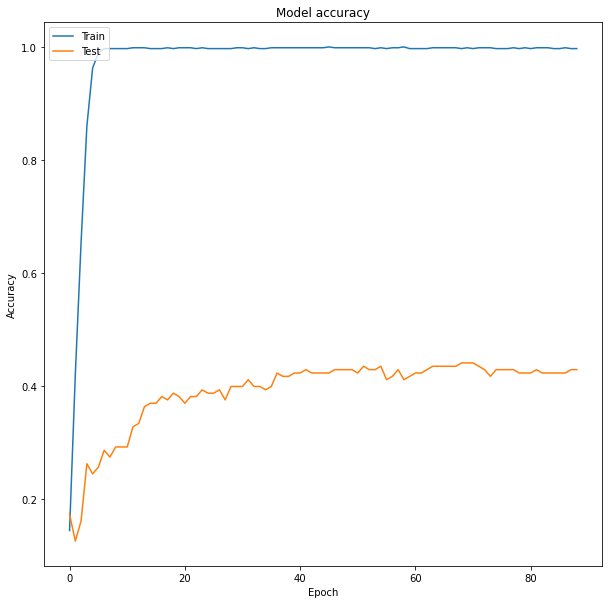

6/6 - 1s - loss: 2.9067 - accuracy: 0.4405


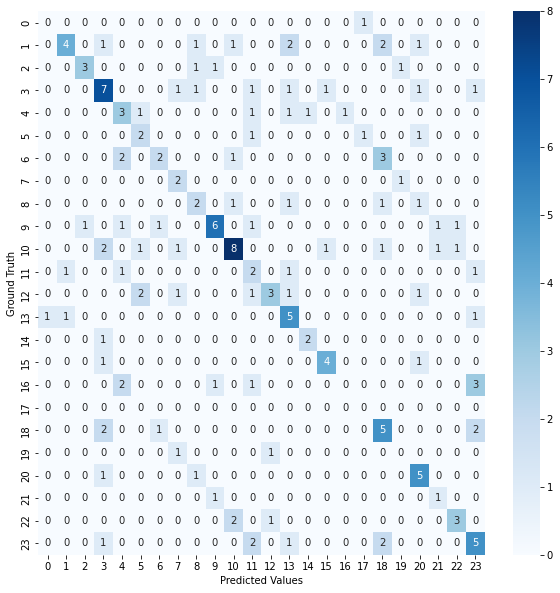


Evaluation accuracy: 44.05 % - loss: 2.91


In [21]:
model = models.Sequential()
model.add(layers.Conv2D(24, (5,5), kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same', input_shape=(12, 1000, 1)))# input_shape=(144,150,1)
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.1))

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001),  activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.Conv2D(24, (5,5),kernel_regularizer=regularizers.l2(0.001), activation='elu',padding='same'))
model.add(layers.BatchNormalization())

model.add(layers.AveragePooling2D(pool_size = (1,12)))
model.add(layers.Flatten())

model.add(layers.Dense(48, activation='relu'))
model.add(layers.Dense(24, activation='softmax'))

model.summary()
sgd = optimizers.SGD(lr=0.001, decay=1e-4, momentum=0.9)
model.compile(optimizer=sgd,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

print("\nTraining")

callback = [callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) , callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)]
	  
history = model.fit(dataset[:n,:,:], target[:n], epochs=100,verbose=1,validation_data = (dataset[n+1:,:,:], target[n+1:]),callbacks=callback)

print("\nModel Trained, Evaluation: \n")
figure = plt.figure(figsize=(10, 10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
loss, acc = model.evaluate(dataset[n+1:,:,:], target[n+1:], verbose=2)

if True:
  y_pred = model.predict(dataset[n+1:,:,:])
  matrix = sklearn.metrics.confusion_matrix(keras.utils.to_categorical(target[n+1:]).argmax(axis=1), y_pred.argmax(axis=1))
  figure = plt.figure(figsize=(10, 10))
  import seaborn as sns
  sns.heatmap(matrix, annot=True, cmap = plt.cm.Blues)
  plt.xlabel('Predicted Values')
  plt.ylabel('Ground Truth')
  plt.show()

print('\nEvaluation accuracy: %.2f %% - loss: %.2f' % (acc*100, loss))
